In [ ]:
# load sample images using scikit learn 


In [64]:
import numpy as np
import torch 
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.v2 as T
import torch.nn as nn
import torch.nn.functional as F

In [8]:
images = load_sample_images()['images']

In [11]:
images[0].shape

(427, 640, 3)

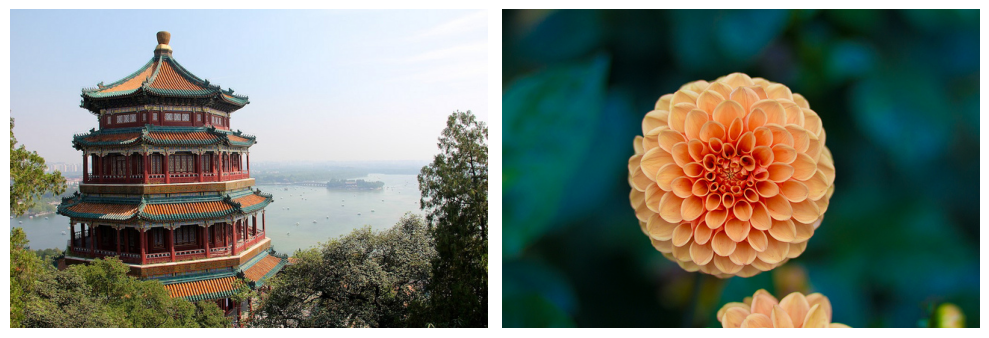

In [ ]:
fig , axis = plt.subplots(nrows = 1 , ncols = 2 , figsize=(10 , 10))
plt.sca(axis[0])
plt.imshow(images[0])
plt.axis('off')
plt.sca(axis[1])
plt.imshow(images[1])
plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
# lets stack these iamges 

sample_images = np.stack(images)

#lets conver to tenosr

In [28]:
sample_images = torch.tensor(sample_images , dtype=torch.float32) / 255

# divided by 255 to normalize the rgb values

In [30]:
sample_images.shape

# 2 batch images , height , width and channel

torch.Size([2, 427, 640, 3])

In [31]:
# pytorch excepts channle dimensions to be before height and width not after so lets change 

In [33]:
sample_images_permuted = sample_images.permute(0 , 3 , 1 ,2)
sample_images_permuted.shape

#batch size , channel , height , width

torch.Size([2, 3, 427, 640])

In [35]:
# center crop the images which means to cut the edges of the imaegs 
# it assumes that the most detail is present at the center

In [38]:
cropped_images = T.CenterCrop((70 , 120))(sample_images_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

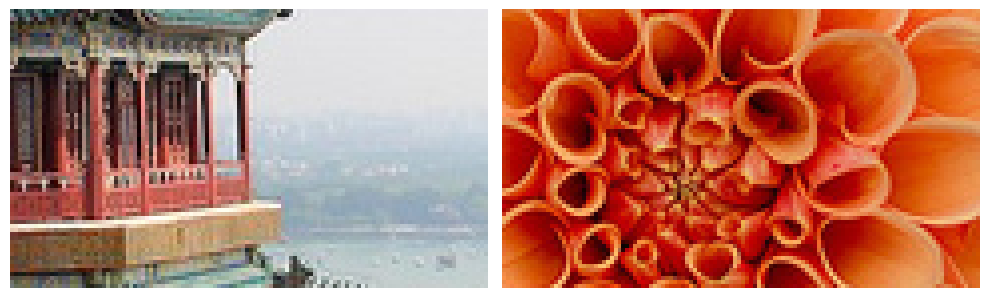

In [47]:
#see 
fig , ax = plt.subplots(1 , 2 , figsize=(10 ,10))
for i in range(2):
    img_to_show = cropped_images[i]
    img_to_show_permute = img_to_show.permute(1 , 2 , 0).numpy()
    ax[i].imshow(img_to_show_permute)
    ax[i].set_axis_off()
   
plt.tight_layout()
plt.show()  
    


In [48]:
#create 2d convolution layer 

In [52]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3 , out_channels=32 , kernel_size=7)
fmaps = conv_layer(cropped_images)

# in channels = rgb , looking for 32 different patterns and each neurons looks at 7x7 filed 

In [54]:
# pixel lost on edges due to no padding also called valid padding or padding = 0 default

fmaps.shape

torch.Size([2, 32, 64, 114])

In [55]:
# padding = same ensures same ouput dimensions

In [56]:
conv_layer = nn.Conv2d(in_channels=3 , out_channels=32 , kernel_size=7 ,
                       padding='same')
fmaps = conv_layer(cropped_images)

In [58]:
fmaps.shape

torch.Size([2, 32, 70, 120])

In [59]:
# the weight and the bias parameter
print(f' weigth : {conv_layer.weight.shape} , bias : {conv_layer.bias.shape}')

 weigth : torch.Size([32, 3, 7, 7]) , bias : torch.Size([32])


In [60]:
# the pooling layer 

In [61]:
# we will make a max pooling layer 

In [62]:
max_pool = nn.MaxPool2d(kernel_size=2)

In [63]:
# average pooling layer 

avg_pool = nn.AvgPool2d(kernel_size=2)

In [67]:
# depth pooling layer

class DepthPool(torch.nn.Module):
    def __init__(self , kernel_size , stride=None , padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding # default is valid padding 
        
    def forward(self , inputs):
        batch , channels , height , width = inputs.shape
        z = inputs.view(batch , channels , height * width)
        z = z.permute(0 , 2 , 1)
        z = F.max_pool1d(z , kernel_size=self.kernel_size , stride = self.stride , 
                         padding= self.padding)
        z = z.permute(0 , 2 ,1)
        
        return z.view(batch , -1 , height , width)      #un permutes


In [68]:
# global average pooling laer 

global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
output = global_avg_pool(cropped_images)